In [61]:
# Python imports
import os
import math

# PyTorch imports
import torch
import torchvision

# Third-party imports
import matplotlib.pyplot as plt
from tabulate import tabulate

# Own imports
import utils

# 0. Constants

In [48]:
WIDTH, HEIGHT = 28, 28
CATEGORIES = 10
BATCH_SIZE = 10
LEARNING_RATE = 0.01
EPOCHS = 10
KERNEL_SIZES = [5, 5]
CHANNELS = [1, 6, 16]
FC_LAYER_SIZES = [120, 84]
SAVED_FILENAME = 'MNIST-CNN-LeNet'

# 1. Dataset

In [49]:
# Load datasets.
dataset_training = torchvision.datasets.MNIST('./data', download=True, train=True, transform=torchvision.transforms.ToTensor())
dataset_test = torchvision.datasets.MNIST('./data', download=True, train=False, transform=torchvision.transforms.ToTensor())

# Create data loaders.
dataloader_training = torch.utils.data.DataLoader(dataset_training, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

# 2. Model

In [50]:
num_inputs_to_fc_layer = int(((WIDTH / 2 - 4) / 2) * ((HEIGHT / 2 - 4) / 2)) * CHANNELS[2]

model = torch.nn.Sequential(
    torch.nn.Conv2d(CHANNELS[0], CHANNELS[1], KERNEL_SIZES[0], padding='same'),
    torch.nn.AvgPool2d(2),
    torch.nn.Conv2d(CHANNELS[1], CHANNELS[2], KERNEL_SIZES[1]),
    torch.nn.AvgPool2d(2),
    torch.nn.Flatten(),
    torch.nn.Linear(num_inputs_to_fc_layer, FC_LAYER_SIZES[0]),
    torch.nn.Linear(FC_LAYER_SIZES[0], FC_LAYER_SIZES[1]),
    torch.nn.Linear(FC_LAYER_SIZES[1], CATEGORIES),
    torch.nn.Softmax(dim=1),
)

print(model)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=400, out_features=120, bias=True)
  (6): Linear(in_features=120, out_features=84, bias=True)
  (7): Linear(in_features=84, out_features=10, bias=True)
  (8): Softmax(dim=1)
)


## 2.1. Statistics of the Model

In [51]:
num_parameters_total = 0
for params in model.parameters():
    num_parameters = 1
    size = params.size()
    for dim_size in size:
        num_parameters *= dim_size
    num_parameters_total += num_parameters

print(f'Total number of parameters: {num_parameters_total}')

Total number of parameters: 61706


# 3. Training

## 3.1. Helper Functions

In [52]:
def calculateStatistics(dataloader, model, loss_fn):
    with torch.no_grad():
        num_batches = len(dataloader)
        num_samples = len(dataloader.dataset)
        loss, correct = 0, 0

        for images, labels in dataloader:
            # Make predictions.
            preds = model(images)

            # Calculate the loss.
            loss += loss_fn(preds, labels).item()

            # Calculate the number of correctnesses.
            correct += (preds.argmax(dim=1) == labels).type(dtype=torch.float32).sum().item()

        # Calculate the mean loss and correct.
        loss /= num_batches
        correct /= num_samples

    return loss, correct

In [53]:
def getGrads(model):
    grads_weight = []
    grads_bias = []

    for layer in model:
        if type(layer) == torch.nn.Conv2d or type(layer) == torch.nn.Linear:
            grads_weight.append(layer.weight.grad.clone())
            grads_bias.append(layer.bias.grad.clone())

    return grads_weight, grads_bias

In [54]:
def load(model):
    # Retrieve saved data.
    data = torch.load(f'saved/{SAVED_FILENAME}.pt')

    # Resume model from saved data.
    state_dict = data['state_dict']
    model.load_state_dict(state_dict)

    # Return losses and accuracies for training and testing.
    return data['losses'], data['corrects'], data['losses_test'], data['corrects_test'], data['grads'], data['duration']

In [55]:
def save(model, losses, corrects, losses_test, corrects_test, grads, duration):
    # Create folder 'saved' if it does not exist.
    if not os.path.exists('saved'):
        os.makedirs('saved')

    # Construct the struct of data to save.
    data = {
        'state_dict': model.state_dict(),
        'losses': losses,
        'corrects': corrects,
        'losses_test': losses_test,
        'corrects_test': corrects_test,
        'grads': grads,
        'duration': duration,
    }

    # Save data to the file.
    torch.save(data, f'saved/{SAVED_FILENAME}.pt')

## 3.2. Training Function

In [56]:
def train(model, epochs, learning_rate):
    # Define a timer and start timing.
    t = utils.Timer()
    t.start()

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), learning_rate)

    # Define losses and corrects for training and test.
    losses, corrects = [], []
    losses_test, corrects_test = [], []

    # Define the grad variables.
    grads = []

    # Calculate losses and corrects before training.
    loss, correct = calculateStatistics(dataloader_training, model, loss_fn)
    losses.append(loss)
    corrects.append(correct)
    loss_test, correct_test = calculateStatistics(dataloader_test, model, loss_fn)
    losses_test.append(loss)
    corrects_test.append(correct_test)

    # Print statistics.
    print(f'Training error: loss: {loss:>7f}, accuracy: {correct*100:>0.1f}%')
    print(f'Test error: loss: {loss_test:>7f}, accuracy: {correct_test*100:>0.1f}%')

    # Run epochs.
    for epoch in range(epochs):

        # Run one epoch for training.
        num_batches = len(dataloader_training)
        num_samples = len(dataloader_training.dataset)
        loss_epoch, correct_epoch = 0, 0
        grads_weight_epoch, grads_bias_epoch = None, None
        for batch, [images, labels] in enumerate(dataloader_training):
            # Make predictions.
            pred = model(images)

            # Calculate the loss.
            loss = loss_fn(pred, labels)
            loss_epoch += loss.item()

            # Calculate the number of correctness.
            correct_epoch += (pred.argmax(dim=1) == labels).type(dtype=torch.float32).sum().item()

            # Calculate gradients.
            optimizer.zero_grad()
            loss.backward()

            # Store the gradients.
            grads_weight_batch, grads_bias_batch = getGrads(model)
            if grads_weight_epoch == None:
                grads_weight_epoch = grads_weight_batch
            else:
                for i in range(len(grads_weight_epoch)):
                    grads_weight_epoch[i] += grads_weight_batch[i]
            if  grads_bias_epoch == None:
                grads_bias_epoch = grads_bias_batch
            else:
                for i in range(len(grads_bias_epoch)):
                    grads_bias_epoch[i] += grads_bias_batch[i]

            # Optimization.
            optimizer.step()

            if (batch + 1) % 1000 == 0:
                loss, size_current, size_total = loss.item(), (batch+1)*BATCH_SIZE, len(dataloader_training.dataset)
                print(f'loss: {loss:>7f} [{size_current:>5d} / {size_total:>5d}]')
            
        # Calculate the mean loss across all batches.
        loss_epoch /= num_batches
        losses.append(loss_epoch)

        # Calculate the mean number of correctness across all batches.
        correct_epoch /= num_samples
        corrects.append(correct_epoch)

        for i in range(len(grads_bias_epoch)):
            grads_weight_epoch[i] /= num_batches
        for i in range(len(grads_bias_epoch)):
            grads_bias_epoch[i] /= num_batches
        grads.append({
            'weight': grads_weight_epoch,
            'bias': grads_bias_epoch,
        })

        # Print statistics of the training part of the epoch.
        print(f'Training error: loss: {loss_epoch:>7f}, accuracy: {correct_epoch*100:>0.1f}%')

        # Calculate loss and correct for test.
        loss_test, correct_test = calculateStatistics(dataloader_test, model, loss_fn)
        losses_test.append(loss_test)
        corrects_test.append(correct_test)

        # Print statistics of the test part of the epoch.
        print(f'Test error: loss: {loss_test:>7f}, accuracy: {correct_test*100:>0.1f}%')

    # Stop timing.
    t.stop()

    # Return losses and accuracies for training and testing, as well as the training duration.
    return losses, corrects, losses_test, corrects_test, grads, t.getDuration()

## 3.3. Training

In [57]:
if os.path.exists(f'saved/{SAVED_FILENAME}.pt'):
    losses, corrects, losses_test, corrects_test, grads, duration = load(model)
else:
    losses, corrects, losses_test, corrects_test, grads, duration = train(model, EPOCHS, LEARNING_RATE)
    save(model, losses, corrects, losses_test, corrects_test, grads, duration)

Training error: loss: 2.302813, accuracy: 11.6%
Test error: loss: 2.302734, accuracy: 12.2%
loss: 2.295628 [10000 / 60000]
loss: 2.302418 [20000 / 60000]
loss: 2.294107 [30000 / 60000]
loss: 2.268204 [40000 / 60000]
loss: 1.771669 [50000 / 60000]
loss: 1.671700 [60000 / 60000]
Training error: loss: 2.163523, accuracy: 35.1%
Test error: loss: 1.683829, accuracy: 78.9%
loss: 1.671977 [10000 / 60000]
loss: 1.464268 [20000 / 60000]
loss: 1.660773 [30000 / 60000]
loss: 1.661551 [40000 / 60000]
loss: 1.657370 [50000 / 60000]
loss: 1.856379 [60000 / 60000]
Training error: loss: 1.653577, accuracy: 81.2%
Test error: loss: 1.630820, accuracy: 83.2%
loss: 1.661657 [10000 / 60000]
loss: 1.564000 [20000 / 60000]
loss: 1.559893 [30000 / 60000]
loss: 1.559929 [40000 / 60000]
loss: 1.567895 [50000 / 60000]
loss: 1.530945 [60000 / 60000]
Training error: loss: 1.590890, accuracy: 87.3%
Test error: loss: 1.568101, accuracy: 89.4%
loss: 1.541304 [10000 / 60000]
loss: 1.731233 [20000 / 60000]
loss: 1.7583

## 3.3. Visualization of the Training Process

### 3.3.1. Training Time

In [58]:
print(f'Training time: {duration:.2f} seconds')

Training time: 213.22 seconds


### 3.3.2. Visualization of Losses and Accuracies

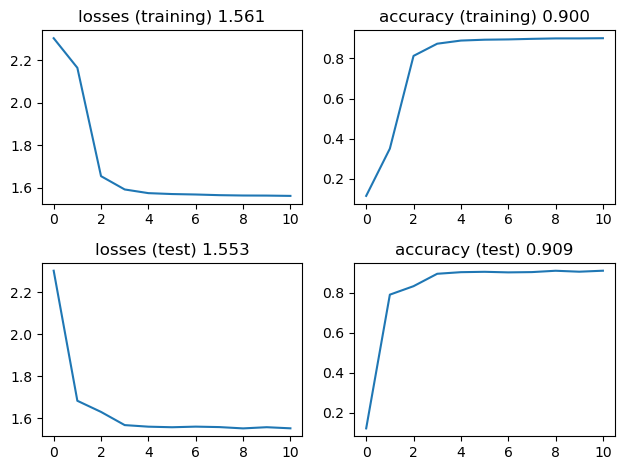

In [59]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2,2)

ax11.plot(losses)
ax11.set_title(f'losses (training) {losses[EPOCHS]:.3f}')
ax12.plot(corrects)
ax12.set_title(f'accuracy (training) {corrects[EPOCHS]:.3f}')
ax21.plot(losses_test)
ax21.set_title(f'losses (test) {losses_test[EPOCHS]:.3f}')
ax22.plot(corrects_test)
ax22.set_title(f'accuracy (test) {corrects_test[EPOCHS]:.3f}')

plt.tight_layout()
plt.show()

### 3.3.2. Visualization of Gradients

Calculate the mean and variance of the absolute values of gradients.

In [67]:
# Define how many rows to show in the table.
ROWS = 3 if len(grads) >= 3 else len(grads)

table = []
for row in range(ROWS):
    # Calculate which epoch to display.
    if row == ROWS - 1:
        index = EPOCHS - 1
    else:
        index = math.floor((EPOCHS / (ROWS - 1))) * row

    row_data = [
        f'Epoch #{index+1}',
        f'{grads[index]["weight"][0].abs().mean().item():.0e} ({grads[index]["weight"][0].abs().var().item():.0e})',
        f'{grads[index]["bias"][0].abs().mean().item():.0e} ({grads[index]["bias"][0].abs().var().item():.0e})',
        f'{grads[index]["weight"][1].abs().mean().item():.0e} ({grads[index]["weight"][1].abs().var().item():.0e})',
        f'{grads[index]["bias"][1].abs().mean().item():.0e} ({grads[index]["bias"][1].abs().var().item():.0e})',
        f'{grads[index]["weight"][2].abs().mean().item():.0e} ({grads[index]["weight"][2].abs().var().item():.0e})',
        f'{grads[index]["bias"][2].abs().mean().item():.0e} ({grads[index]["bias"][2].abs().var().item():.0e})',
        f'{grads[index]["weight"][3].abs().mean().item():.0e} ({grads[index]["weight"][3].abs().var().item():.0e})',
        f'{grads[index]["bias"][3].abs().mean().item():.0e} ({grads[index]["bias"][3].abs().var().item():.0e})',
        f'{grads[index]["weight"][4].abs().mean().item():.0e} ({grads[index]["weight"][4].abs().var().item():.0e})',
        f'{grads[index]["bias"][4].abs().mean().item():.0e} ({grads[index]["bias"][4].abs().var().item():.0e})',
    ]

    table.append(row_data)

print(tabulate(table, tablefmt='github', headers=['Epoch', 'Layer #1 - Weight', 'Layer #1 - Bias', 'Layer #2 - Weight', 'Layer #2 - Bias', 'Layer #3 - Weight', 'Layer #3 - Bias', 'Layer #4 - Weight', 'Layer #4 - Bias', 'Layer #5 - Weight', 'Layer #5 - Bias']))

| Epoch     | Layer #1 - Weight   | Layer #1 - Bias   | Layer #2 - Weight   | Layer #2 - Bias   | Layer #3 - Weight   | Layer #3 - Bias   | Layer #4 - Weight   | Layer #4 - Bias   | Layer #5 - Weight   | Layer #5 - Bias   |
|-----------|---------------------|-------------------|---------------------|-------------------|---------------------|-------------------|---------------------|-------------------|---------------------|-------------------|
| Epoch #1  | 2e-03 (2e-06)       | 1e-03 (3e-07)     | 4e-04 (1e-07)       | 2e-04 (3e-08)     | 9e-05 (8e-09)       | 6e-05 (2e-09)     | 1e-04 (1e-08)       | 1e-04 (8e-09)     | 6e-04 (2e-07)       | 5e-04 (3e-07)     |
| Epoch #6  | 1e-04 (6e-09)       | 5e-04 (8e-08)     | 5e-05 (2e-09)       | 1e-04 (6e-09)     | 3e-05 (6e-10)       | 3e-05 (4e-10)     | 3e-05 (5e-10)       | 3e-05 (4e-10)     | 1e-04 (7e-09)       | 5e-05 (5e-09)     |
| Epoch #10 | 9e-05 (6e-09)       | 4e-04 (4e-08)     | 5e-05 (2e-09)       | 6e-05 (2e-09)     | 3e-05 